# ResNet-34 Transfer Learning for Plant Classification (Random Split)
Zero Additional Hidden Layer

In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import RandAugment
import matplotlib.pyplot as plt
import time


In [2]:
train_transform = transforms.Compose([
    RandAugment(),  #RandAug
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  #Imagenet mean & std
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [3]:
train_folder = r"C:\Users\dhani\Documents\Tugas Akhir and Stuff\Dataset Rand\train"
test_folder = r"C:\Users\dhani\Documents\Tugas Akhir and Stuff\Dataset Rand\test"

train_dataset = ImageFolder(root=train_folder, transform=train_transform)
test_dataset = ImageFolder(root=test_folder, transform=test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train dataset: {len(train_dataset)} images, {len(train_dataset.classes)} classes.")
print(f"Test dataset: {len(test_dataset)} images, {len(test_dataset.classes)} classes.")

Train dataset: 3120 images, 52 classes.
Test dataset: 2080 images, 52 classes.


In [4]:
from torchvision.models import resnet34, ResNet34_Weights, resnet50, ResNet50_Weights, resnet101,ResNet101_Weights

weights34 = ResNet34_Weights.IMAGENET1K_V1
weights50 = ResNet50_Weights.IMAGENET1K_V1
weights101 = ResNet101_Weights.IMAGENET1K_V1
model = resnet34(weights=weights34)

#freeze conv
for param in model.parameters():
    param.requires_grad = False

# fc layer config
num_classes = 52
# zerolayer
model.fc = nn.Linear(model.fc.in_features, num_classes)  

# onelayer
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Linear(512, num_classes)        
# )       

# twolayer
# model.fc = nn.Sequential(
#     nn.Linear(model.fc.in_features, 512),
#     nn.ReLU(),
#     nn.Linear(512, 512),
#     nn.ReLU(),
#     nn.Linear(512, num_classes)        
# )                                                      

#parameter set
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.fc.parameters(), lr=0.001)

device = torch.device('cuda')
model = model.to(device)


Epoch [1/50], Train Loss: 3.0441, Val Loss: 1.7890, Train Accuracy: 30.80%, Val Accuracy: 70.87%, Train F1: 0.3075, Val F1: 0.6911, Time: 24.49 seconds
Epoch [2/50], Train Loss: 1.6451, Val Loss: 1.0401, Train Accuracy: 70.29%, Val Accuracy: 82.21%, Train F1: 0.6939, Val F1: 0.8144, Time: 23.91 seconds
Epoch [3/50], Train Loss: 1.1240, Val Loss: 0.7402, Train Accuracy: 79.01%, Val Accuracy: 86.73%, Train F1: 0.7867, Val F1: 0.8685, Time: 24.17 seconds
Epoch [4/50], Train Loss: 0.8885, Val Loss: 0.5938, Train Accuracy: 82.15%, Val Accuracy: 88.46%, Train F1: 0.8203, Val F1: 0.8845, Time: 24.74 seconds
Epoch [5/50], Train Loss: 0.7415, Val Loss: 0.5385, Train Accuracy: 84.55%, Val Accuracy: 87.74%, Train F1: 0.8445, Val F1: 0.8754, Time: 27.81 seconds
Epoch [6/50], Train Loss: 0.6620, Val Loss: 0.4635, Train Accuracy: 86.09%, Val Accuracy: 89.86%, Train F1: 0.8595, Val F1: 0.8988, Time: 25.67 seconds
Epoch [7/50], Train Loss: 0.5956, Val Loss: 0.4348, Train Accuracy: 87.18%, Val Accuracy

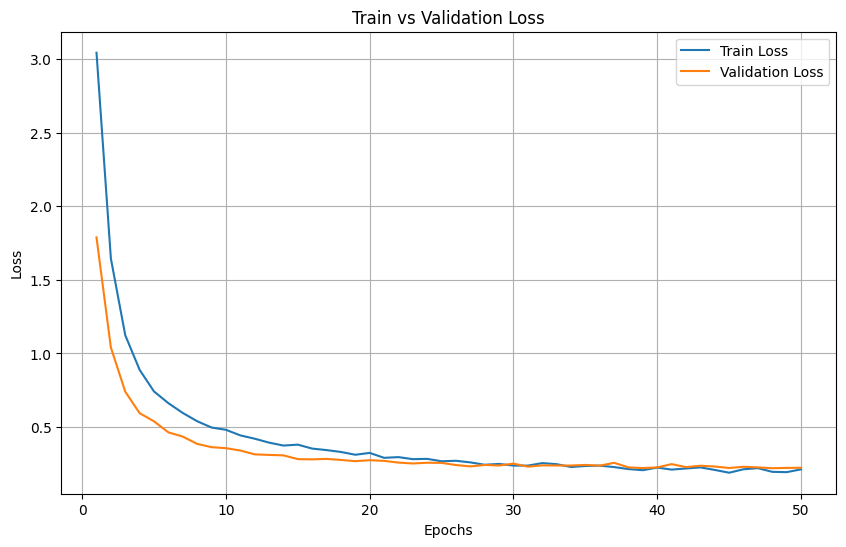

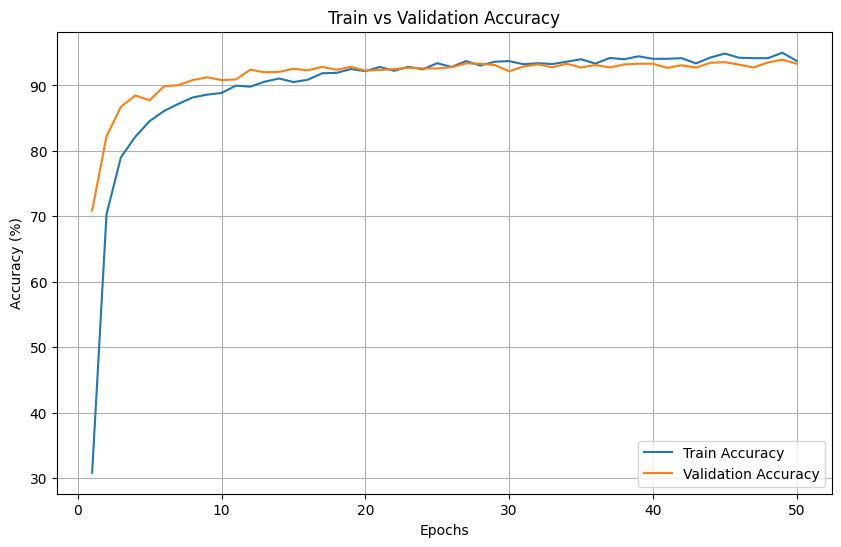

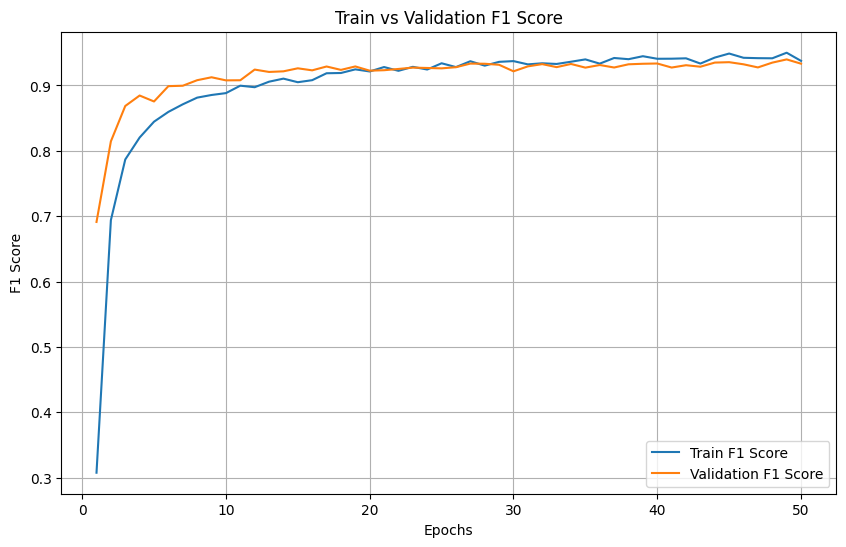

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import time

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []

total_start_time = time.time()

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_train_labels = []
    all_train_preds = []

    start_time = time.time()

    # Train loop
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forwardprop
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    # Train loss, accuracy, F1 score
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_f1 = f1_score(all_train_labels, all_train_preds, average='macro')

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_f1_scores.append(train_f1)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_val_labels = []
    all_val_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    # Val loss, accuracy,  F1 score
    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_f1_scores.append(val_f1)

    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%, "
          f"Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Time: {epoch_time:.2f} seconds")

total_training_time = time.time() - total_start_time
print(f"Total Training Time: {total_training_time:.2f} seconds")

results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Train Loss': train_losses,
    'Val Loss': val_losses,
    'Train Accuracy': train_accuracies,
    'Val Accuracy': val_accuracies,
    'Train F1 Score': train_f1_scores,
    'Val F1 Score': val_f1_scores
})
results_df.to_csv('training_results_with_34_0_random.csv', index=False)


In [6]:
#savemodel
torch.save(model.state_dict(), "resnet34_ZeroLayer_random.pth")